In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import cpt

In [3]:
p11, p22, p33 = 0.5, 0.5, 0 #density matrix values
p12, p13, p23 = 0, 0, 0
P0 = np.array([p11, p22, p12, p13, p23], dtype='complex')

### example of using cpt.ramsey_resonance()

In [74]:
I1=1
I2=3
w1=cpt.get_w1(I1)
w2=cpt.get_w2(I2)
w1

6606320.532394711

In [92]:
(detuning, ptot) = cpt.ramsey_resonance(10e-6, 10e-6, 0.3e-6, P0, I1, I2, 1e6, n=201, fs=0.01e-6, ms=0.1e-6)

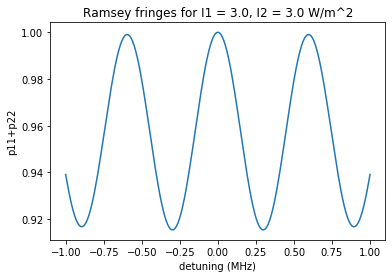

In [93]:
plt.xlabel('detuning (MHz)')
plt.ylabel('p11+p22')
plt.title('Ramsey fringes for I1 = '+ str(I1) +', I2 = '+ str(I2) + ' W/m^2')
plt.plot(detuning*1e-6, ptot.real)

### saving resonance spectra in csv files

In [58]:
# write spectrum to file

def writespec(filename, detuning, ptot):
    with open(filename, "w") as datafile:
        writer = csv.writer(datafile)
        writer.writerow(['detuning (MHz)', 'p11+p22'])
        for i in range(detuning.size):
            writer.writerow([detuning[i]*1e-6, ptot[i].real])
    return

In [101]:
'''
for I1_times4 in range(2, 13):
    for I2_times4 in range(I1_times4, 13):
        I1 = I1_times4 / 4
        I2 = I2_times4 / 4
        (detuning, ptot) = cpt.ramsey_resonance(10e-6, 10e-6, 0.3e-6, P0, I1, I2, 1e6, n=201, fs=0.01e-6, ms=0.1e-6)
        filename='highres_I1=' + str(I1) + ',I2=' + str(I2) + ".csv"
        writespec(filename, detuning, ptot)

### finding contrast and linewidth

In [102]:
# find oscillating height of largest fringe
# height = maxvalue - minvalue

def fringe_osc_height(df, colname='p11+p22'):
    minp=maxp=0.97
    for p in df[colname]:
        if (p < minp):
            minp = p
        elif (p > maxp):
            maxp = p

    osc_height = maxp-minp
    return osc_height


In [103]:
# find average height of largest fringe
# avg_height = (maxheight + minheight) / 2

# (note: assume largest fringe is near center of data, and has approximately cosine shape)

def fringe_avg_height(df, colname='p11+p22'):
    n=df.shape[0]
    starti=int(n/4)
    stopi=int(n*3/4)
    df2 = df.loc[starti : stopi]  # look at center chunk of data
    minp=maxp=0.97
    for p in df2[colname]:
        if (p < minp):
            minp = p
        elif (p > maxp):
            maxp = p
    
    avg_height = (maxp + minp) / 2
    return avg_height


In [104]:
def fringe_contrast(df, colname='p11+p22'):
    
    osc_h = fringe_osc_height(df, colname)
    avg_h = fringe_avg_height(df, colname)
    
    contrast = osc_h / avg_h
    return contrast


In [105]:
# find fwhm of largest fringe
# (note: assume largest fringe is near center of data, and has approximately cosine shape)

def fringe_fwhm(df, xname='detuning (MHz)', yname='p11+p22'):
    n=df.shape[0]
    starti=int(n/4)
    stopi=int(n*3/4)
    df2 = df.loc[starti : stopi]  # look at center chunk of data
    
    # find max value and index
    maxy=0.97
    maxi=0
    for i in range(starti , stopi):
        if (df2[yname][i] > maxy):
            maxy = df2[yname][i]
            maxi = i
            
    # find index of left minimum
    leftmini=rightmini=0
    prev=maxy
    for i in range(maxi-1, starti, -1):
        if (df2[yname][i] > prev):
            leftmini = i+1
            break
        prev = df2[yname][i]

    # find index of right minimum
    prev=maxy
    for i in range(maxi+1, stopi):
        if (df2[yname][i] > prev):
            rightmini = i-1
            break
        prev = df2[yname][i]
    
    # find indices of half maximums
    lmidi = int((leftmini+maxi) / 2)
    rmidi = int((rightmini+maxi) / 2)
    
    fwhm = df2[xname][rmidi] - df2[xname][lmidi]
    return fwhm


In [107]:
rams  = [['I1', 'I2', 'contrast', 'fwhm']]

for I1_times4 in range(2, 13):
    for I2_times4 in range(I1_times4, 13):
        I1 = I1_times4 / 4
        I2 = I2_times4 / 4
        filename='highres_I1=' + str(I1) + ',I2=' + str(I2) + ".csv"
        d='detuning (MHz)'
        p='p11+p22'

        df = pd.read_csv(filename)
        row = [I1, I2, fringe_contrast(df), fringe_fwhm(df)]
        rams.append(row)
        

In [108]:
rams_df = pd.DataFrame(data=rams[1:], columns=rams[0])
#rams_df.to_csv('highres_ramdata200.csv')

In [123]:
ramdat = pd.read_csv('highres_ramdata200.csv', index_col=0)

In [124]:
inten1=[]
inten15=[]
inten2=[]
inten25=[]
inten3=[]
for row in ramdat.itertuples(index=False, name=None):
    if (row[0]==1):
        inten1.append([row[1], row[2], row[3]])
    elif (row[0]==1.5):
        inten15.append([row[1], row[2], row[3]])
    elif (row[0]==2):
        inten2.append([row[1], row[2], row[3]])
    elif (row[0]==2.5):
        inten25.append([row[1], row[2], row[3]])
    elif (row[0]==3):
        inten3.append([row[1], row[2], row[3]])


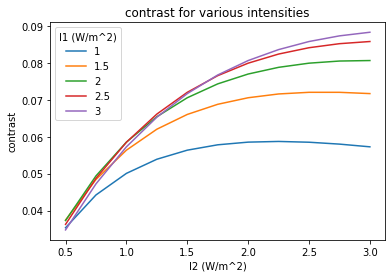

In [125]:
df1 = pd.DataFrame(data=inten1, columns=['I2', 'contrast', 'fwhm'])
df15 = pd.DataFrame(data=inten15, columns=['I2', 'contrast', 'fwhm'])
df2 = pd.DataFrame(data=inten2, columns=['I2', 'contrast', 'fwhm'])
df25 = pd.DataFrame(data=inten25, columns=['I2', 'contrast', 'fwhm'])
df3 = pd.DataFrame(data=inten3, columns=['I2', 'contrast', 'fwhm'])

plt.title('contrast for various intensities')
plt.xlabel('I2 (W/m^2)')
plt.ylabel('contrast')


plt.plot(df1['I2'], df1['contrast'], label='1')
plt.plot(df15['I2'], df15['contrast'], label='1.5')
plt.plot(df2['I2'], df2['contrast'], label='2')
plt.plot(df25['I2'], df25['contrast'], label='2.5')
plt.plot(df3['I2'], df3['contrast'], label='3')
plt.legend(title='I1 (W/m^2)')

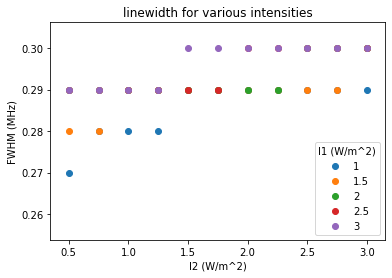

In [133]:
plt.title('linewidth for various intensities')
plt.xlabel('I2 (W/m^2)')
plt.ylabel('FWHM (MHz)')


plt.scatter(df1['I2'], df1['fwhm'], label='1')
plt.scatter(df15['I2'], df15['fwhm'], label='1.5')
plt.scatter(df2['I2'], df2['fwhm'], label='2')
plt.scatter(df25['I2'], df25['fwhm'], label='2.5')
plt.scatter(df3['I2'], df3['fwhm'], label='3')
plt.legend(title='I1 (W/m^2)', loc='lower right')